1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Global minima:				(x,y) = (-0.090,0.713)
Value of f in global minima:		f(x,y) = -1.032

Minimization using x0=(0,0) as initial guess:		(x,y) = (0.000,0.000)


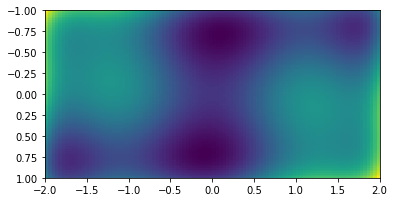

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import imshow
from scipy.optimize import minimize, basinhopping

def f(var):
    x, y = var
    return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2

x=np.linspace(-2,2,100)
y=np.linspace(-1,1,100)
X, Y = np.meshgrid(x,y)
Z=f([X,Y])
imshow(Z,extent=[-2,2,1,-1])


# finding the global minima, enumerating them and compute the aqlue of f in such points
results=basinhopping(f,[0,-0.75])               # using basinhopping to span all the grid searching a minima
print('Global minima:\t\t\t\t(x,y) = (%.3f,%.3f)' % (results.x[0],results.x[1]))
# it appears that the function f has two global minima, located in (x,y) (showed in output) ans -(x,y). Indeed, the function is 
    # even both in x and in y variables. Changin the parameter x0 when calling basinhopping, it's possible to obtain in output
    # the other global minima point.
print('Value of f in global minima:\t\tf(x,y) = %.3f' %results.fun)

# investigating what happens when (x0,y0)=(0,0)
results=minimize(f,[0,0])
print('\nMinimization using x0=(0,0) as initial guess:\t\t(x,y) = (%.3f,%.3f)' %(results.x[0],results.x[1]))
# What we see is that the minimization process gets stuck in a saddle point, which is (0,0). Assuming the minimizer uses
    # a gradient descent algorithm to obtain the minimum, starting from (0,0) has the effect to produce a null gradient, which
    # reflects in stopping the minimization.

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

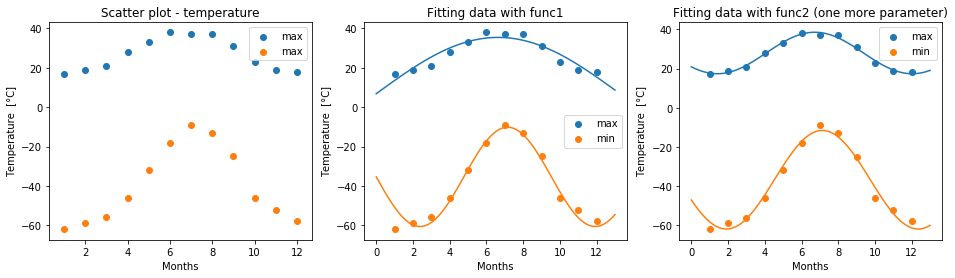

F-Test - 3 vs 4 parameters (max temperatures):
	CL: 0.000 , additional parameter necessary: YES
F-Test - 3 vs 4 parameters (min temperatures):
	CL: 0.015 , additional parameter necessary: YES

Time offset parameter for fitmax =	-2.4 +/- 0.1
Time offset parameter for fitmin =	0.4 +/- 0.2
Compatibility = 12.881


In [2]:
from scipy.optimize import curve_fit
from scipy.stats import f

max_=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months=np.arange(12)+1

# plotting the temperatures
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].scatter(months,max_,label='max')
ax[0].scatter(months,min_,label='max')
ax[0].set_xlabel('Months')
ax[0].set_ylabel('Temperature  [°C]')
ax[0].legend(loc='best')
ax[0].set_title('Scatter plot - temperature')

# defining the function for the fit
def func1(x,A,B,D):
    return A*np.sin(B*x)+D
def func2(x,A,B,C,D):
    return A*np.sin(B*x+C)+D

# fitting the data
fitmax1=curve_fit(func1,months,max_,p0=[10,0.5,30])          # fitting the data with func1
fitmin1=curve_fit(func1,months,min_,p0=[30,0.5,-30])
fitmax2=curve_fit(func2,months,max_,p0=[10,0.5,0,30])        # fitting the data with func2 (one more parameter)
fitmin2=curve_fit(func2,months,min_,p0=[30,0.5,0,-30])

# plotting the results
x_range=np.linspace(0,13,100)
ax[1].scatter(months,max_,label='max')
ax[1].scatter(months,min_,label='min')
ax[1].plot(x_range,func1(x_range,fitmax1[0][0],fitmax1[0][1],fitmax1[0][2]))
ax[1].plot(x_range,func1(x_range,fitmin1[0][0],fitmin1[0][1],fitmin1[0][2]))
ax[1].set_xlabel('Months')
ax[1].set_ylabel('Temperature  [°C]')
ax[1].legend(loc='best')
ax[1].set_title('Fitting data with func1')
ax[2].scatter(months,max_,label='max')
ax[2].scatter(months,min_,label='min')
ax[2].plot(x_range,func2(x_range,fitmax2[0][0],fitmax2[0][1],fitmax2[0][2],fitmax2[0][3]))
ax[2].plot(x_range,func2(x_range,fitmin2[0][0],fitmin2[0][1],fitmin2[0][2],fitmin2[0][3]))
ax[2].set_xlabel('Months')
ax[2].set_ylabel('Temperature  [°C]')
ax[2].legend(loc='best')
ax[2].set_title('Fitting data with func2 (one more parameter)')
plt.show()

# checking if the fit is reasonable (F-test)
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("\tCL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ssrmax_1=np.sum((max_-func1(months,fitmax1[0][0],fitmax1[0][1],fitmax1[0][2]))**2)
ssrmin_1=np.sum((min_-func1(months,fitmin1[0][0],fitmin1[0][1],fitmin1[0][2]))**2)
ssrmax_2=np.sum((max_-func2(months,fitmax2[0][0],fitmax2[0][1],fitmax2[0][2],fitmax2[0][3]))**2)
ssrmin_2=np.sum((min_-func2(months,fitmin2[0][0],fitmin2[0][1],fitmin2[0][2],fitmin2[0][3]))**2)
print("F-Test - 3 vs 4 parameters (max temperatures):")
Ftest(ssrmax_1,ssrmax_2,2,3,12,verbose=True)
print("F-Test - 3 vs 4 parameters (min temperatures):")
Ftest(ssrmin_1,ssrmin_2,2,3,12,verbose=True)
# The first fit isn't good, indeed the fisher test shows a confidence level below 10%. The fit using func2 is instead reasonable
    # The curves seems to fit well the data (and honestly I don't know where to add another parameter to run another F-test)

# last task
print('\nTime offset parameter for fitmax =\t%.1f +/- %.1f' %(fitmax2[0][2],np.sqrt(fitmax2[1][2,2])))
print('Time offset parameter for fitmin =\t%.1f +/- %.1f' %(fitmin2[0][2],np.sqrt(fitmin2[1][2,2])))
print('Compatibility = %.3f' %(abs(fitmax2[0][2]-fitmin2[0][2])/np.sqrt(fitmax2[1][2,2]+fitmin2[1][2,2])))
# the time offsets are not comparable, even if it seems it has to be watching the plots; the two traslations are even of
    # opposite sign. This may be due to some imperfection of the fitting process, caused by the limited number of data points.
    # Indeed, watching the fit function of the minimun temperatures, it seems that at the bond of the plot the fitted model
    # rise too fast. This cause a slightly wrong prediction of the minimum and so arise some errors in the computation of the
    # time offset parameter

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

PARAMETERS:
A = 616 +/- 8
mu = -0.115 +/- 0.003
sigma = 0.266 +/- 0.002


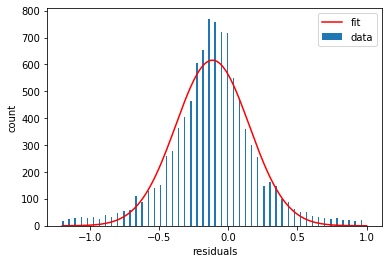

Chi2 test:  p value = 0.00000
Chi2 = 10025.000


In [3]:
import pickle
from scipy.stats import chi2

# importing the data
with open('residuals_261.pkl', 'rb') as f:
    data = pickle.load(f)
data=data.item()
res, dist = data['residuals'], data['distances']

# creating and plotting the histogram
bin_value, bin_edge=np.histogram(res,range=(-1.2,1),bins=50)
plt.bar(bin_edge[:-1],bin_value,align='edge',width=0.01,label='data')
plt.xlabel('residuals')
plt.ylabel('count')

# setting the error on the bin values and performing the fit
err=np.sqrt(bin_value)
def gaussian(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))
[A, mu, sigma], cov = curve_fit(gaussian,bin_edge[:-1],bin_value,p0=[1000,0,0.2],sigma=err,absolute_sigma=True)

# writing parameters and plotting the curve obtained by the fit
print('PARAMETERS:')
print('A = %.0f +/- %.0f' %(A,np.sqrt(cov[0,0])))
print('mu = %.3f +/- %.3f' %(mu,np.sqrt(cov[1,1])))
print('sigma = %.3f +/- %.3f' %(sigma,np.sqrt(cov[2,2])))
xr=np.linspace(-1.2,1,200)
plt.plot(xr,gaussian(xr,A,mu,sigma),'r',label='fit')
plt.legend(loc='best')
plt.show()

# performing a goodness-of-fit test
chi = np.sum((bin_value-gaussian(bin_value,A,mu,sigma))**2/err**2)
p_value = 1 - chi2.cdf(chi,len(bin_value)-1)
print('Chi2 test:  p value = %.5f' %p_value)
print('Chi2 = %.3f' %chi)
# the p-value isn't satisfactory, that means that the fit is not a good one. However, looking closely we can guess that the
    # high value of the chi2 is caused by the tails of the histogram, which don't tend to 0 and so force the fit to consider
    # this fact. So, we obtain a gaussian which it's maximum is lower of the peak of the histogram and it's sigma is a bit too
    # large. However, somehow the fit doesn't look so bad, and we can assume that at least the parameter 'mu' is accurate.

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

BEST VALUES OF THE PARAMETERS:
a = (-10.0 +/- 0.1) °C
b = (-0.23 +/- 0.01) rad
c = (9.26 +/- 0.09) °C

Average temperature in Munich 9.29 °C
Hottest temperature of the year 19.22 °C
Coldest temperature of the year -0.70 °C


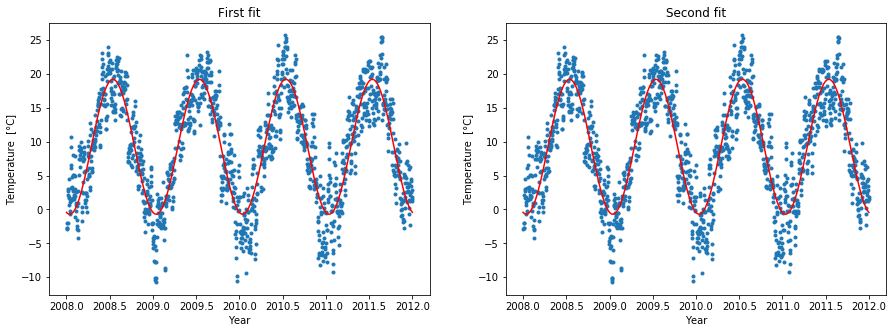


BEST VALUES OF THE PARAMETERS:
a = (-10.0 +/- 0.1) °C
b = (1.000 +/- 0.002) 1/year
c = (-4 +/- 24) rad
d = (9.3 +/- 0.1) °C

CL: 1.000 , additional parameter necessary: NO


1.0

In [4]:
from math import floor
import scipy.stats as stats

time=[]
T=[]
with open('munich_temperatures_average_with_bad_data.txt','r') as file:
    for line in file:
        t=line.split(' ')
        time.append(float(t[0]))
        T.append(float(t[1]))
        
# deleting those values that are clearly generated by wrong measurements
time, T = np.array(time), np.array(T)
time=time[T<50]
T=T[T<50]
time=time[T>-50]
T=T[T>-50]

# selected only the range [2008,2012]
T=T[time>=2008]
time=time[time>=2008]
T=T[time<=2012]
time=time[time<=2012]

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time,T,'.')

# fitting the data with the first function
def func1(x,a,b,c):
    return a*np.cos(2*np.pi*x+b)+c
par1, cov1 = curve_fit(func1,time,T,p0=[35,0,15])
xr=np.linspace(2008,2012,400)
ax[0].plot(xr,func1(xr,par1[0],par1[1],par1[2]),'r')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature  [°C]')
ax[0].set_title('First fit')

print('BEST VALUES OF THE PARAMETERS:')
print('a = (%.1f +/- %.1f) °C' %(par1[0],np.sqrt(cov1[0,0])))
print('b = (%.2f +/- %.2f) rad' %(par1[1],np.sqrt(cov1[1,1])))
print('c = (%.2f +/- %.2f) °C' %(par1[2],np.sqrt(cov1[2,2])))
print('\nAverage temperature in Munich %.2f °C' %(np.mean(func1(xr,par1[0],par1[2],par1[2]))))
print('Hottest temperature of the year %.2f °C' %(max(func1(xr,par1[0],par1[2],par1[2]))))
print('Coldest temperature of the year %.2f °C' %(min(func1(xr,par1[0],par1[2],par1[2]))))

# The b parameters evaluate the phase of the cosine function to fit the data. The physical sense of the parameter is to
    # translate the fitted function to the right or to the left, so deciding when (in the period of an year) we observe the
    # maximum and the minimum temperatures

# fitting the data with the second function
def func2(x,a,b,c,d):
    return a*np.cos(2*np.pi*b*x+c)+d
par2, cov2 = curve_fit(func2,time,T,p0=[-10,1,-0.2,9.3])
ax[1].plot(time,T,'.')
ax[1].plot(xr,func2(xr,par2[0],par2[1],par2[2],par2[3]),'r')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature  [°C]')
ax[1].set_title('Second fit')
plt.show()
print('\nBEST VALUES OF THE PARAMETERS:')
print('a = (%.1f +/- %.1f) °C' %(par2[0],np.sqrt(cov2[0,0])))
print('b = (%.3f +/- %.3f) 1/year' %(par2[1],np.sqrt(cov2[1,1])))
print('c = (%.0f +/- %.0f) rad' %(par2[2],np.sqrt(cov2[2,2])))
print('d = (%.1f +/- %.1f) °C' %(par2[3],np.sqrt(cov2[3,3])))

# F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("\nCL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL
rss_1=np.sum((T-func1(time,par1[0],par1[1],par1[2]))**2)
rss_2=np.sum((T-func2(time,par2[0],par2[1],par2[2],par2[2]))**2)
Ftest(rss_1,rss_2,2,3,len(time),verbose=True)